

<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Artificial Intelligence <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Spring 2025<br>
<font color=3C99D size=5>
    Practical Assignment 3
    <br>
     Hidden Markov Models -Bayes Net <br>
<font color=696880 size=4>
Amirardalan Dehghanpour


# HMM Assignment

 –Sequence Modeling with Hidden Markov Models (HMM)

## Part 1: HMM Models


Introduce the concept of Hidden Markov Models (HMMs) and their applications in sequence modeling.

### -What is an HMM?
A Hidden Markov Model is a statistical model that represents systems with:
1. **Hidden states** – not directly observable (e.g., phonemes, weather conditions, gene regions).
2. **Observable outputs** – emitted signals or features (e.g., audio features, weather observations).

### - Key Components of an HMM:
- **States (Z)**: Hidden variables (e.g., phonemes in speech recognition).
- **Observations (X)**: Observable features (e.g., MFCCs from audio).
- **Initial Probabilities (π)**: Probability of starting in a particular state.
- **Transition Probabilities (A)**: Probability of moving from one state to another.
- **Emission Probabilities (B)**: Probability of observing a value given a state.

### -HMM Process Overview:
At each time step `t`, the system:
1. Transitions from one state to another using **transition probability A**
2. Emits an observation using **emission probability B**

### - Why Use HMMs?
HMMs are useful for modeling sequential data where the underlying structure is hidden but can be inferred from observations.

#### Example Applications:
- **Speech Recognition** – Infer phonemes from audio features
- **Natural Language Processing** – POS tagging, named entity recognition
- **Bioinformatics** – Identify coding vs. non-coding DNA regions
- **Finance** – Regime detection in time series

---

 In this part, we will:
- Work with dna datasets
- Extract HMM parameters from data
- Implement HMM algorithms from scratch
- Visualize results to understand hidden sequences



## Part 2: Extract HMM Parameters from DNA Dataset ##

In this section, you'll use a labeled DNA dataset to extract the core parameters of a Hidden Markov Model:
- **Initial Probabilities** – likelihood of starting in a specific hidden state
- **Transition Matrix** – probabilities of switching from one hidden state to another
- **Emission Matrix** – probabilities of emitting a specific observation given the hidden state

We are given labeled sequences of DNA nucleotides with associated hidden states (`Coding` or `NonCoding`). Using this, we can compute the HMM parameters as follows:


####  Initial Probabilities (π)
- For each sequence, check the **first position** (Position == 1).
- Count how many times each hidden state appears at the start.
- Normalize the counts to get the starting probability distribution.

####  Transition Probabilities (A)
- For each sequence, look at every **pair of consecutive states** (from Position _t_ to _t+1_).
- Count how often each transition occurs (e.g., Coding → Coding, Coding → NonCoding).
- For each state, normalize its outgoing transition counts to sum to 1.

####  Emission Probabilities (B)
- For each state, count how frequently it emits each nucleotide (A, C, G, T).
- Normalize these counts within each state.

This method is based on **maximum likelihood estimation(MLE)** using frequency counts, which is valid because we have access to the true hidden states.
These parameters will be used in later for performing inference (Forward/Viterbi).



 ## Load the Dataset ##

In [98]:
# Load the synthetic DNA dataset
# It contains Sequence_ID, Position, Nucleotide (A/C/G/T), and State (Coding/NonCoding).

import pandas as pd
import numpy as np
# Load dataset
df = pd.read_csv('dna_dataset.csv')

# Preview the data
df.head()

,Sequence_ID,Position,Nucleotide,State
0,1,1,A,Coding
1,1,2,G,NonCoding
2,1,3,G,Coding
3,1,4,A,NonCoding
4,1,5,T,Coding


## Identify Unique States and Observations ##

In [99]:
# Get the unique hidden states and observable symbols (nucleotides).
# This helps us define our state and observation spaces for the HMM.
# states =
unique_states = df["State"].unique()
print(f"States: {unique_states}")

# observations =
unique_observations = sorted(df["Nucleotide"].unique())
print(f"Observations: {unique_observations}")


States: ['Coding' 'NonCoding']
Observations: ['A', 'C', 'G', 'T']


## Estimate Initial Probabilities (π) ##

In [100]:
# Compute the probability of starting in each state.
# This is based on the first position of each sequence in the dataset.

# Count how often each state appears as the first state in a sequence
initial_probs = {}
total = df['State'].count()
state_counts = df['State'].value_counts()
for state in unique_states:
    initial_probs[state] = f"{state_counts.get(state, 0) / total:.2f}"


print("Initial Probabilities (π):", initial_probs)


Initial Probabilities (π): {'Coding': '0.51', 'NonCoding': '0.49'}


## Estimate Transition Probabilities (A) ##

In [101]:
# Compute the probability of transitioning from one hidden state to another.
# Based on how states change within each sequence.

# Count transitions between states
states = df['State'].dropna().tolist()
transition_probs = {state: {next_state: 0 for next_state in unique_states} for state in unique_states}

for i in range(len(states) - 1):
    transition_probs[states[i]][states[i + 1]] += 1

for from_state in transition_probs:
    total = sum(transition_probs[from_state].values())
    if total > 0:
        for to_state in transition_probs[from_state]:
            transition_probs[from_state][to_state] /= total

print("Transition Probabilities (A):")
for from_state, to_probs in transition_probs.items():
    print(from_state, "→", to_probs)


Transition Probabilities (A):
Coding → {'Coding': 0.4461162677088422, 'NonCoding': 0.5538837322911578}
NonCoding → {'Coding': 0.5805284358571721, 'NonCoding': 0.4194715641428279}


## Estimate Emission Probabilities (B) ##

In [102]:
# Compute the probability of emitting a given nucleotide from each hidden state.
# Based on how frequently each nucleotide appears for a given state.

# Count emissions for each (state, observation) pair
emissions = df['Nucleotide'].dropna().tolist()
emission_probs = {state: {emission: 0 for emission in unique_observations} for state in unique_states}

for i in range(len(states)):
    emission_probs[states[i]][emissions[i]] += 1

for state in emission_probs:
    total = sum(emission_probs[state].values())
    if total > 0:
        for emission in emission_probs[state]:
            emission_probs[state][emission] /= total
    

print("Emission Probabilities (B):")
for state, probs in emission_probs.items():
    print(state, "→", probs)


Emission Probabilities (B):
Coding → {'A': 0.2556261195245074, 'C': 0.2506757857026543, 'G': 0.24950333821853118, 'T': 0.2441947565543071}
NonCoding → {'A': 0.35343915343915344, 'C': 0.14794333504010923, 'G': 0.1501962792285373, 'T': 0.3484212322922}


## Part 4: Forward Algorithm (Filtering with Elapse Time + Observation)

The **Forward Algorithm** helps us compute the probability of an observation sequence in a Hidden Markov Model (HMM). It also gives us the belief about the system's hidden state at each time step.

To do this, it recursively applies two updates at each time step `t`:


###  Step 1: Elapse Time (Prediction)
Predict the probability of being in each hidden state at time `t`, before seeing the new observation:

$$
P(x_t | e_{1:t-1}) = \sum_{x_{t-1}} P(x_t | x_{t-1}) \cdot P(x_{t-1} | e_{1:t-1})
$$

This uses the **transition probabilities (A)** and previous beliefs.


###  Step 2: Observation Update (Bayesian Update)
Once we see the new observation `e_t`, we update our beliefs:

$$
P(x_t | e_{1:t}) \propto P(e_t | x_t) \cdot P(x_t | e_{1:t-1})
$$

This uses the **emission probabilities (B)** and normalizes the result.


### Final Result:
- We maintain a belief `α_t(x)` for each state `x` at every time step.
- We can compute the total probability of the sequence by summing the final α values.



In [103]:
def elapse_time(prior, transition_probs, states):
    """
    Predicts the belief at time t using the belief at time t-1 and transition matrix A.

    Parameters:
    - prior: dict of P(state at t-1 | evidence up to t-1)
    - transition_probs: dict of dicts P(to_state | from_state)
    - states: list of possible states

    Returns:
    - prediction: dict of P(state at t | evidence up to t-1)
    """

    prediction = {state: 0.0 for state in states}
    for current_state in states:
        for from_state in states:
            prediction[current_state] += transition_probs[from_state][current_state] * prior[from_state]

    return prediction


In [104]:
def observe(predicted, observation, emission_probs, states):
    """
    Updates the belief at time t after seeing observation e_t, using emission matrix B.

    Parameters:
    - predicted: dict of P(state at t | evidence up to t-1)
    - observation: the observed symbol at time t (e.g., 'A')
    - emission_probs: dict of dicts P(obs | state)
    - states: list of possible states

    Returns:
    - updated: dict of P(state at t | evidence up to t)
    """

    updated = {state: 0.0 for state in states}
    for current_state in states:
        updated[current_state] = emission_probs[current_state][observation] * predicted[current_state]
    
    total = sum(updated.values())
    for _ in states:
        updated[_] /= total

    return updated


In [105]:
def forward_algorithm(observation_sequence, states, start_probs, transition_probs, emission_probs):
    """
    Runs the full forward algorithm over an observation sequence.

    Parameters:
    - observation_sequence: list of observations (e.g., ['A', 'C', 'T', ...])
    - states: list of hidden states
    - start_probs: initial state distribution (π)
    - transition_probs: transition matrix A
    - emission_probs: emission matrix B

    Returns:
    - alpha_list: list of belief dicts (α_t) over time
    - sequence_prob: total probability of the full observation sequence
    """

    alpha_list = []
    first_belief = {state: 0.0 for state in states}
    for starting_state in states:
        first_belief[starting_state] = emission_probs[starting_state][observation_sequence[0]] * float(start_probs[starting_state])
    total = sum(first_belief.values())
    for _ in first_belief:
        first_belief[_] /= total
    alpha_list.append(first_belief)

    for i in range(1, len(observation_sequence)):
        predicted = elapse_time(alpha_list[-1], transition_probs, states)
        alpha_list.append(observe(predicted, observation_sequence[i], emission_probs, states))
    
    return alpha_list, sum(alpha_list[-1].values())


    


In [106]:
# Small test case
test_sequence = ['A','C','C','T','T','T','A','G']

# Run forward algorithm
alpha_vals, prob = forward_algorithm(
    test_sequence,
    unique_states,
    initial_probs,
    transition_probs,
    emission_probs
)

print(f"\nTotal probability of sequence {test_sequence}: {prob:.6f}")
print("\nBelief at final time step:")
for state, p in alpha_vals[-1].items():
    print(f"P({state}) = {p:.4f}")



Total probability of sequence ['A', 'C', 'C', 'T', 'T', 'T', 'A', 'G']: 1.000000

Belief at final time step:
P(Coding) = 0.6439
P(NonCoding) = 0.3561


## Part 5: Viterbi Algorithm – Most Likely State Sequence

While the Forward Algorithm gives us the probability of a sequence of observations, the **Viterbi Algorithm** answers a different question:

> What is the **most likely sequence of hidden states** that could have generated this observation sequence?



The Viterbi Algorithm is a dynamic programming approach. At each time step `t`, it keeps track of:

- The **highest probability path** to each state.
- A **backpointer** that tells us which state led to that one.

###  Two Main Steps:

1. **Recursion (Forward Pass):**
$$
\delta_t(s) = \max_{s'} [\delta_{t-1}(s') \cdot P(s | s')] \cdot P(obs_t | s)
$$

2. **Backtracking (Backward Pass):**
$$
\text{Backtrace from final best state} \rightarrow \text{recover most likely path}
$$





In [107]:
def viterbi(obs, states, start_p, trans_p, emit_p):
    """
    Viterbi algorithm to find the most probable sequence of hidden states.

    Parameters:
    - obs: list of observations (e.g., ['A', 'C', 'T', ...])
    - states: list of hidden states (e.g., ['Coding', 'NonCoding'])
    - start_p: initial state probabilities
    - trans_p: transition probability matrix
    - emit_p: emission probability matrix

    Returns:
    - prob: probability of the most likely state sequence
    - path: list of most likely hidden states
    """

    likely_list, likely_path = [], []
    first_belief = {state: 0.0 for state in states}
    for starting_state in states:
        first_belief[starting_state] = emission_probs[starting_state][obs[0]] * float(start_p[starting_state])
    total = sum(first_belief.values())
    for _ in first_belief:
        first_belief[_] /= total
    likely_list.append(first_belief)

    for i in range(1, len(obs)):
        mlprob, mlpath = most_likely_step(likely_list[-1], obs[i], states, trans_p, emit_p)
        likely_list.append(mlprob)
        likely_path.append(mlpath)

    max_prob, max_last_state = 0.0, None
    for last_state in states:
        if likely_list[-1][last_state] > max_prob:
            max_prob = likely_list[-1][last_state]
            max_last_state = last_state
        
    path = [None for _ in obs]
    path[-1] = max_last_state
    for i in range(len(obs) - 2, -1, -1):
        path[i] = likely_path[i][path[i + 1]]

    return max_prob, path



def most_likely_step(prior, observation, states, transition_probs, emission_probs):
    likely_probs, likely_path = {state: 0.0 for state in states}, {state: None for state in states}
    for current_state in states:
        max_prob, max_prev_state = 0.0, None
        for from_state in states:
            if prior[from_state] * transition_probs[from_state][current_state] > max_prob:
                max_prob = prior[from_state] * transition_probs[from_state][current_state]
                max_prev_state = from_state
        max_prob *= emission_probs[current_state][observation]
        likely_probs[current_state], likely_path[current_state] = max_prob, max_prev_state
    
    return likely_probs, likely_path
    


In [108]:
obs_seq = ['A', 'C', 'G', 'T', 'A','A', 'C', 'C', 'C', 'A']

prob, most_likely_path = viterbi(
    obs_seq,
    unique_states,
    initial_probs,
    transition_probs,
    emission_probs
)

print("Observation sequence:", obs_seq)
print("Most likely state sequence:", most_likely_path)
print("Probability of this path:", prob)



Observation sequence: ['A', 'C', 'G', 'T', 'A', 'A', 'C', 'C', 'C', 'A']
Most likely state sequence: ['NonCoding', 'Coding', 'Coding', 'NonCoding', 'Coding', 'NonCoding', 'Coding', 'Coding', 'Coding', 'NonCoding']
Probability of this path: 1.8459061363207946e-08


## Part 6: Visualizing the Most Likely Hidden State Sequence (Viterbi Path)

After using the Viterbi algorithm, we get the **most likely sequence of hidden states** that could have produced the given observations.

In this part, we'll:
1. Visually display the Viterbi path over time.
2. Compare it with the **true hidden state sequence** (if known).
3. Visualize it on top of the **Forward Algorithm belief heatmap**.

This helps understand where the model is confident, where it might be uncertain, and how accurate the predictions are.


In [109]:
import matplotlib.pyplot as plt

def plot_viterbi_path(viterbi_path, states, title="Viterbi Most Likely Path"):
    """
    Plots the Viterbi path as a step timeline of states.
    
    Parameters:
    - viterbi_path: list of predicted states from Viterbi algorithm
    - states: list of possible hidden states
    """
    state_to_y = {state: i for i, state in enumerate(states)}
    
    y_vals = [state_to_y[state] for state in viterbi_path]
    x_vals = list(range(len(viterbi_path)))

    x_step = []
    y_step = []

    for i in range(len(y_vals)):
        if i > 0:
            x_step.append(i)
            y_step.append(y_vals[i-1])
        x_step.append(i)
        y_step.append(y_vals[i])

    # Plot
    plt.figure(figsize=(14, 3))
    plt.step(x_step, y_step, where='post', color='red', linewidth=2)
    plt.yticks(list(state_to_y.values()), list(state_to_y.keys()))
    plt.xticks(x_vals, [f"t={i}" for i in x_vals], rotation=45)
    plt.ylim(-0.5, len(states)-0.5)
    plt.xlim(-0.5, len(viterbi_path) - 0.5)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Hidden State")
    plt.tight_layout()
    plt.show()


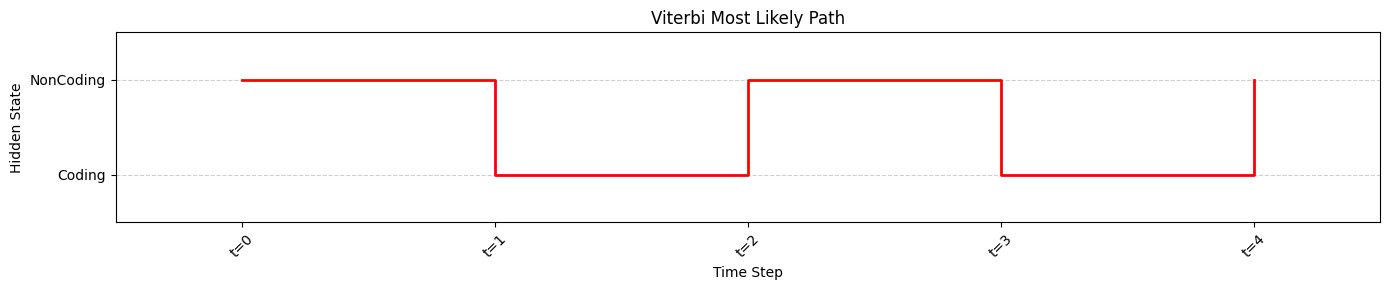

In [51]:
# Run Viterbi on example observation sequence
obs_seq = ['A', 'C', 'T', 'G', 'A']
prob, viterbi_path = viterbi(obs_seq, unique_states, initial_probs, transition_probs, emission_probs)


# Plot the path
plot_viterbi_path(viterbi_path, unique_states)


# Bayesian Networks

In this assignment, we will work with a Bayesian Network based on a scenario: **a group of friends deciding whether to order pizza** and how that decision, along with other factors, affects their evening satisfaction.

We'll learn how to:
- Represent a Bayesian Network
- Define its conditional probability tables (CPTs)
- Implement inference algorithms

---

## Scenario

Imagine a group of friends planning their evening. They may or may not be hungry. It might be a weekend. These factors influence whether they decide to order pizza. If pizza is ordered **and** friends are free, they might plan a movie night. The presence of a movie night then affects how satisfied they are.

---

## 🔍 Variables

| Variable | Description | Values |
|----------|-------------|--------|
| `H` | It's a hungry day | {True, False} |
| `W` | It's the weekend | {True, False} |
| `P` | They order pizza | {True, False} |
| `F` | Friends are free | {True, False} |
| `M` | Movie night is planned | {True, False} |
| `S` | Satisfaction level | {'high', 'medium', 'low'} |

---

## 🔗 Network Structure

The relationships among the variables and their conditional probablities follow these tables:

### P(H) — Hungry
| H     | P(H) |
|-------|------|
| True  | 0.6  |
| False | 0.4  |

### P(W) — Weekend
| W     | P(W) |
|-------|------|
| True  | 0.3  |
| False | 0.7  |

### P(F) — Friends Free
| F     | P(F) |
|-------|------|
| True  | 0.8  |
| False | 0.2  |

### P(P | H, W) — Pizza
| H     | W     | P(P=True) | P(P=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.95      | 0.05       |
| True  | False | 0.7       | 0.3        |
| False | True  | 0.5       | 0.5        |
| False | False | 0.1       | 0.9        |

### P(M | P, F) — Movie Night
| P     | F     | P(M=True) | P(M=False) |
|-------|-------|-----------|------------|
| True  | True  | 0.9       | 0.1        |
| True  | False | 0.4       | 0.6        |
| False | True  | 0.6       | 0.4        |
| False | False | 0.2       | 0.8        |

### P(S | M) — Satisfaction
| M     | S        | P(S)   |
|-------|----------|--------|
| True  | high     | 0.7    |
|       | medium   | 0.25   |
|       | low      | 0.05   |
| False | high     | 0.1    |
|       | medium   | 0.3    |
|       | low      | 0.6    |




###  Step 1: Define and Visualize the Bayesian Network
#### Your task in this step:
##### 1. Draw the Bayesian Network using networkx and matplotlib
##### 2. Create a dictionary called `bayes_net` that stores all variables, their parents, and their CPTs

In [110]:
import networkx as nx
import matplotlib.pyplot as plt

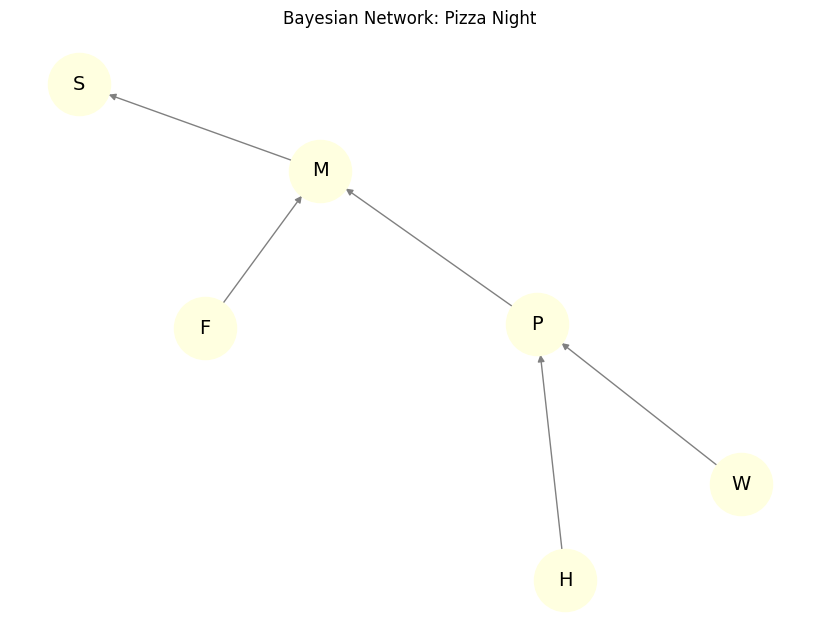

0.7


In [111]:
# === STEP 1: Define and Visualize the Bayesian Network ===
# ---------------------------------------------------------

# Your tasks in this step:
# 1. Draw the Bayesian Network using networkx and matplotlib
# 2. Define the Bayesian Network structure and CPTs using a dictionary
# 3. Implement a helper function to retrieve probabilities from CPTs

# --- Draw the graph ---

import networkx as nx
import matplotlib.pyplot as plt

# 📌 Create a directed graph and add edges between variables
G = nx.DiGraph()

G.add_node('H')
G.add_node('W')
G.add_node('P')
G.add_node('F')
G.add_node('M')
G.add_node('S')

# Add edges based on the Pizza Night Bayes Net
# Example: G.add_edge('H', 'P')
# Add the correct edges here
# G.add_edge(...)

G.add_edge('H', 'P')
G.add_edge('W', 'P')
G.add_edge('P', 'M')
G.add_edge('F', 'M')
G.add_edge('M', 'S')


# Draw the graph
plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightyellow',
        font_size=14, edge_color='gray')
plt.title("Bayesian Network: Pizza Night")
plt.show()


# --- TODO: Define the Bayesian Network as a dictionary ---

bayes_net = {
    'H': {
        'parents': [],
        'cpt': {
            True: 0.6,
            False: 0.4
        }
    },
    'W': {
        'parents': [],
        'cpt': {
            True: 0.3,
            False: 0.7
        }
    },
    'P': {
        'parents': ['H', 'W'],
        'cpt': {
            # (H, W)
            (True, True) : {
                True: 0.95,
                False: 0.05
            },
            (True, False): {
                True: 0.7,
                False: 0.3
            },
            (False, True) : {
                True: 0.5,
                False: 0.5
            },
            (False, False): {
                True: 0.1,
                False: 0.9
            }
        }
    },
    'F': {
        'parents': [],
        'cpt': {
            True: 0.8,
            False: 0.2
        }
    },
    'M': {
        'parents': ['P', 'F'],
        'cpt': {
            # (P, F)
            (True, True): {
                True: 0.9,
                False: 0.1
            },
            (True, False): {
                True: 0.4,
                False: 0.6
            },
            (False, True): {
                True: 0.6,
                False: 0.4
            },
            (False, False): {
                True: 0.2,
                False: 0.8
            }
        }
    },
    'S': {
        'parents': ['M'],
        'cpt': {
            # M
            True: {
                'high': 0.7,
                'medium': 0.25,
                'low': 0.05
            },
            False: {
                'high': 0.1,
                'medium': 0.3,
                'low': 0.6
            }
        }
    }
}


def get_prob(var, value, evidence, bayes_net):
    """
    Return the probability of var = value given evidence,
    based on the structure and CPTs in the bayes_net dictionary.
    """
    node = bayes_net[var]
    parents = node['parents']
    cpt = node['cpt']

    if not parents:
        return cpt[value]
    else:
        try:
            if len(parents) == 1:
                key = evidence[parents[0]]
            else:
                key = tuple(evidence[parent] for parent in parents)
        except KeyError as e:
            raise ValueError(f"Missing parent '{e.args[0]}' for variable '{var}' in evidence.")

        return cpt[key][value]

# Test your implementation below with this query:
# What is P(P=True | H=True, W=False)?
print(get_prob('P', True, {'H': True, 'W': False}, bayes_net))


# Step 2: Inference by Enumeration

In this step, you'll implement **exact inference** in a Bayesian Network using the **enumeration algorithm**.

---

##  Goal :

We want to compute the probability of a **query variable** given some **evidence**.  
For example:

$$
P(S = \text{high} \mid H = \text{True}, W = \text{True})
$$

To do this, we'll use:

1. **A recursive function `enumerate_all`**  
   - Loops through all hidden variables and sums over them
   - Multiplies conditional probabilities using the Bayesian Network

2. **A main function `query_enum`**  
   - Computes the numerator: probability of the query value given evidence
   - Computes the denominator: normalization over all possible values of the query variable
   - Returns the final **normalized probability**

---






In [112]:
import time

# === STEP 2: Inference by Enumeration ===
# ----------------------------------------

# Your goal in this step:
# Implement exact inference using the enumeration algorithm.

# Given a query variable and some evidence, compute:
#     P(query_var = query_val | evidence)

# Utility: Variables in topological order
variables = ['H', 'W', 'F', 'P', 'M', 'S']

# Implement the recursive enumeration function ---
def enumerate_all(vars_left, evidence, bayes_net):
    """
    Recursively compute the total probability of an assignment
    using the chain rule of probability.

    Args:
        vars_left: list of variables to process
        evidence: current assignment of known variables
        bayes_net: dictionary of CPTs

    Returns:
        total probability of the current evidence
    """

    if len(vars_left) == 0:
        return 1.0

    current_assignment = vars_left[0]
    if current_assignment in evidence.keys():
        vars_left.remove(current_assignment)
        prob = get_prob(current_assignment, evidence[current_assignment], evidence, bayes_net) * enumerate_all(vars_left, evidence, bayes_net)
        vars_left.insert(0, current_assignment)
        return prob
    
    domain = ['high', 'medium', 'low'] if current_assignment == 'S' else [True, False]

        
    sum = 0.0
    vars_left.remove(current_assignment)
    for value in domain:
        evidence[current_assignment] = value
        sum += get_prob(current_assignment, value, evidence, bayes_net) * enumerate_all(vars_left, evidence, bayes_net)

    vars_left.insert(0, current_assignment)
    evidence.pop(current_assignment)
    return sum


# Implement the main query function ---
def query_enum(query_var, query_val, evidence, bayes_net):
    """
    Compute P(query_var = query_val | evidence) using normalization.

    Args:
        query_var: the variable we want to ask about
        query_val: the specific value we're querying
        evidence: dictionary of known values
        bayes_net: full network

    Returns:
        Normalized probability of the query given the evidence
    """

    domain = ['high', 'medium', 'low'] if query_var == 'S' else [True, False]


    denumerator = 0.0

    for value in domain:
        evidence[query_var] = value
        prob = enumerate_all(variables, evidence, bayes_net)
        if value == query_val:
            enumerator = prob
        denumerator += prob

    evidence.pop(query_var)

    return enumerator / denumerator


In [37]:
#  Example: P(S='high' | H=True, W=True)

start = time.time()
result = query_enum('S', 'high', {'H': True, 'W': True}, bayes_net)
end = time.time()
print(f"P(S = 'high' | H=True, W=True) = {result:.4f}")
print(f"Execution time: {end - start:.4f} seconds")


P(S = 'high' | H=True, W=True) = 0.5716
Execution time: 0.0002 seconds


#  Step 3: Inference with Variable Elimination

In this step, you will implement **inference using Variable Elimination** — an exact, more efficient alternative to Enumeration.

---

## Core Ideas:

- Instead of computing the full joint distribution, we work with **factors**.
- A factor is a table mapping variable assignments to probabilities.
- We **join factors** together (multiplication).
- We **eliminate hidden variables** (sum them out).
- At the end, we normalize the final factor.

---

## Inputs
- `query_var`: The variable we're asking about (e.g. `'S'`)
- `query_val`: The value we want (e.g. `'high'`)
- `evidence`: Observed variables
- `bayes_net`: The full Bayesian Network

---

## What You’ll Implement
1. **Factor Construction**: Build initial factors from CPTs.
2. **Restrict for Evidence**: Incorporate evidence early by pruning CPTs.
3. **Join**: Combine factors that mention the same variable.
4. **Eliminate**: Marginalize out variables not in the query or evidence.
5. **Normalize**: Get valid probability distribution.

---



In [113]:
from itertools import product
from copy import deepcopy

# === STEP 3: Variable Elimination ===
# ------------------------------------

#Your goal: Implement inference using Variable Elimination.
# You'll use helper functions to build, combine, and reduce factors,
# and then compute the normalized result of a query given evidence.

# Build a Factor from CPT and Evidence
def make_factor(var, bayes_net, evidence):
    """
    Build a factor for a given variable using its CPT.
    Apply the evidence to skip inconsistent assignments.

    - Get the variable's parents from the Bayes net.
    - Define the domain of each variable (e.g., True/False or high/medium/low).
    - Loop through all combinations of parent and variable values.
    - Skip entries that contradict the evidence.
    - Extract the correct probability from the CPT.
    - Store each valid assignment and its probability in the factor.

    Returns a dictionary with:
    - 'vars': list of variables in the factor
    - 'table': mapping from value assignments (tuples) to probabilities
    """

    parents = bayes_net[var]['parents']
    vars = parents + [var]
    return {
        'table': recursive_assignment(vars, [], evidence, bayes_net, {}),
        'vars': vars
    }
    


def recursive_assignment(vars, assignments, ev, bayes_net, factor):
    if len(assignments) == len(vars) - 1:
        evidence = {vars[i]: assignments[i] for i in range(len(assignments))}
        if vars[-1] in ev:
            prob = get_prob(vars[-1], ev[vars[-1]], evidence, bayes_net)
            evidence[vars[-1]] = ev[vars[-1]]
            factor[tuple(evidence[var] for var in vars)] = prob
            return factor
        
        domain = ['high', 'medium', 'low'] if vars[-1] == 'S' else [True, False]
        
        for value in domain:
            prob = get_prob(vars[-1], value, evidence, bayes_net)
            evidence[vars[-1]] = value
            factor[tuple(evidence[var] for var in vars)] = prob
        return factor
    
    if vars[len(assignments)] in ev:
        assignments.append(ev[vars[len(assignments)]])
        factor = recursive_assignment(vars, assignments, ev, bayes_net, factor)
        assignments.pop()
        return factor

    domain = ['high', 'medium', 'low'] if vars[len(assignments)] == 'S' else [True, False]


    for value in domain:
        assignments.append(value)
        factor = recursive_assignment(vars, assignments, ev, bayes_net, factor)
        assignments.pop()

    return factor
        


# Join Two Factors Together
def join_factors(f1, f2):
    """
    Multiply two factors together to combine their probability tables.

    - Determine the full list of variables across both factors.
    - Loop over all possible assignments to these variables.
    - For each assignment:
        - Extract the relevant sub-assignments for f1 and f2.
        - Multiply the two probabilities (if both exist).
        - Store the result in the new factor.

    Returns a new joined factor with merged variables and probabilities.
    """

    all_vars = list(dict.fromkeys(f1['vars'] + f2['vars']))
    domains = {var: ['high', 'medium', 'low'] if var == 'S' else [True, False] for var in all_vars}
    new_table = {}

    for assignment in product(*[domains[v] for v in all_vars]):
        full_assignment = dict(zip(all_vars, assignment))

        f1_key = tuple(full_assignment[v] for v in f1['vars'])
        f2_key = tuple(full_assignment[v] for v in f2['vars'])

        if f1_key in f1['table'] and f2_key in f2['table']:
            prob = f1['table'][f1_key] * f2['table'][f2_key]
            new_table[assignment] = prob

    return {
        'vars': all_vars,
        'table': new_table
    }



# Eliminate a Variable from a Factor
def eliminate(var, factor):
    """
    Eliminate a variable from a factor by summing over all its values.

    - Remove the eliminated variable from the factor's variable list.
    - For each assignment:
        - Sum over all values of the eliminated variable.
        - Accumulate the total probability in the new factor.

    Returns a new factor without the eliminated variable.
    """
    if var not in factor['vars']:
        return factor

    var_index = factor['vars'].index(var)
    new_vars = factor['vars'][:var_index] + factor['vars'][var_index + 1:]
    new_table = {}

    for key in factor['table']:
        reduced_key = key[:var_index] + key[var_index + 1:]

        if reduced_key not in new_table:
            new_table[reduced_key] = 0.0
        new_table[reduced_key] += factor['table'][key]

    return {
        'vars': new_vars,
        'table': new_table
    }



# Implement Variable Elimination Inference
def query_ve(query_var, query_val, evidence, bayes_net):
    """
    Use variable elimination to compute P(query_var = query_val | evidence).

    Steps:
    1. Build initial factors for all variables using `make_factor`.
    2. Identify all hidden variables (not in evidence or the query).
    3. For each hidden variable:
        - Find all factors containing it.
        - Join those factors using `join_factors`.
        - Eliminate the variable using `eliminate`.
        - Replace old factors with the reduced one.
    4. Join all remaining factors.
    5. Eliminate any remaining variables except the query.
    6. Normalize the result and return the final probability.

    Returns the normalized probability of the query value.
    """

    all_vars = list(bayes_net.keys())

    all_factors = [make_factor(var, bayes_net, evidence) for var in all_vars]

    hidden_vars = [var for var in all_vars if var != query_var and var not in evidence]

    for hidden_var in hidden_vars:
        joining_factors = [f for f in all_factors if hidden_var in f['vars']]
        all_factors = [f for f in all_factors if hidden_var not in f['vars']]

        if not joining_factors:
            continue

        new_factor = joining_factors[0]
        for f in joining_factors[1:]:
            new_factor = join_factors(new_factor, f)

        reduced_factor = eliminate(hidden_var, new_factor)
        all_factors.append(reduced_factor)

    result_factor = all_factors[0]
    for f in all_factors[1:]:
        result_factor = join_factors(result_factor, f)

    remaining_vars = [v for v in result_factor['vars'] if v != query_var]
    for var in remaining_vars:
        result_factor = eliminate(var, result_factor)

    total = sum(result_factor['table'].values())
    normalized_table = {
        k: v / total for k, v in result_factor['table'].items()
    }

    for assignment, prob in normalized_table.items():
        if assignment[0] == query_val:
            return prob

    return 0.0




In [118]:
# Test: What is P(S='high' | H=True, W=True)?
start = time.time()
result_ve = query_ve('S', 'high', {'H': True, 'W': True}, bayes_net)
end = time.time()
print(f"P(S = 'high' | H=True, W=True) = {result_ve:.4f}")
print(f"Execution time: {end - start:.4f} seconds")

P(S = 'high' | H=True, W=True) = 0.5716
Execution time: 0.0004 seconds



## Compare Enumeration vs. Variable Elimination
Explain your answer in each question
1. Do both methods return the **same probability** for your chosen query and evidence? Why or why not? 

+ Yes they did. Because both are derived from one formula and VE only optimizes memory using some reordering in calculations.

2. Which method was **faster** in your tests? Provide the execution times.

+ Enumeration was faster. It took 2 milisecs whereas VE took 4. That's because the inquired query and given bayes net was small and so Enumeration alone works fine on it.

3. Why is **Variable Elimination** usually more efficient than Enumeration, especially for larger networks?

+ Because we use full assignment in Enumeration whereas VE keeps factors small and therefore efficient to work with.

4. Can you think of a scenario where Enumeration might be **simpler or more appropriate** to use than VE?

+ For some networks there's no possible order of variable elimination that keeps factors small and using it only adds overhead of computation compared to Enumeration.

5. What would happen to the performance of each method if the number of variables doubled? Try to explain without coding it.

+ Probably VE would outperform Enumeration.


# Step 4: Approximate Inference with Sampling

In this part, you'll implement two approximate inference algorithms:
- **Rejection Sampling**
- **Likelihood Weighting**

These methods generate random samples from the Bayesian Network to estimate conditional probabilities.

---

##  Rejection Sampling

- Sample all variables from the prior distribution.
- **Reject** any sample that does not match the evidence.
- Among accepted samples, estimate the query probability.


---

##  Likelihood Weighting

- Sample variables in topological order.
- For **evidence variables**, **fix** their value and assign a **weight** equal to the likelihood of observing that value.
- For non-evidence variables, sample normally.
- Compute a weighted average of the query variable.

---

##  Your Tasks

Implement the following:
- `rejection_sampling(query_var, query_val, evidence, bayes_net, N)`
- `likelihood_weighting(query_var, query_val, evidence, bayes_net, N)`


In [119]:
import random


# === STEP 4: Approximate Inference with Sampling ===
# ---------------------------------------------------

# Rejection Sampling ---
def rejection_sampling(query_var, query_val, evidence, bayes_net, N=1000):
    """
    Approximate P(query_var = query_val | evidence) using Rejection Sampling.

    Steps:
    - Generate N samples from the prior using prior_sample().
    - For each sample, check if it matches the evidence.
    - If so, count it as accepted.
    - Among accepted samples, count how many match the query value.
    - Return match / accepted (or 0 if none accepted).
    """

    random.seed(2)

    match, accepted = 0, 0

    for i in range(N):
        sample = prior_sample(bayes_net)
        rejected = False
        for ev in evidence:
            if sample[ev] != evidence[ev]:
                rejected = True
                break

        if rejected:
            continue

        accepted += 1
        if sample[query_var] == query_val:
            match += 1

    if accepted == 0:
        return 0.0
    
    return match / accepted
    


# Likelihood Weighting ---
def likelihood_weighting(query_var, query_val, evidence, bayes_net, N=1000):
    """
    Approximate P(query_var = query_val | evidence) using Likelihood Weighting.

    Steps:
    - For N samples:
        - Call weighted_sample() to get a sample and its weight.
        - Record the weight.
        - Check if query_var equals query_val in the sample.
    - Return weighted average of matches:
        sum(w_i * indicator) / sum(w_i)
    """
    
    random.seed(2)

    match, accepted = 0.0, 0.0

    for i in range(N):
        sample, w = weighted_sample(bayes_net, evidence)
        rejected = False
        for ev in evidence:
            if sample[ev] != evidence[ev]:
                rejected = True
                break

        if rejected:
            continue

        accepted += w
        if sample[query_var] == query_val:
            match += w

    if accepted == 0:
        return 0.0
    
    return match / accepted


# Prior Sampling Helper (for Rejection Sampling) ---
def prior_sample(bayes_net):
    """
    Generate a full sample of all variables from the prior (no evidence used).

    Steps:
    - Loop through variables in topological order.
    - For each variable:
        - Get its parents' sampled values.
        - Look up the correct row in the CPT.
        - Sample the variable's value using weighted random choice.
    - Return the complete sample dictionary.
    """
    
    sample = {}
    for var in bayes_net:
        parents = bayes_net[var]['parents']
        parent_values = {p: sample[p] for p in parents}
        domain = ['high', 'medium', 'low'] if var == 'S' else [True, False]
        probs = [get_prob(var, val, parent_values, bayes_net) for val in domain]
        sample[var] = random.choices(domain, weights=probs)[0]
    return sample

            


# Weighted Sampling Helper (for Likelihood Weighting)
def weighted_sample(bayes_net, evidence):
    """
    Generate a weighted sample using evidence.

    Steps:
    - Loop through variables in topological order.
    - For each variable:
        - If it's an evidence variable:
            - Fix its value to the evidence
            - Update the weight by multiplying with its probability
        - Otherwise:
            - Sample the variable normally from its CPT
    - Return the sample and the associated weight
    """
    sample = {}
    weight = 1.0
    for var in bayes_net:
        parents = bayes_net[var]['parents']
        parent_values = {p: sample[p] for p in parents}
        if var in evidence:
            sample[var] = evidence[var]
            weight *= get_prob(var, evidence[var], sample, bayes_net)
            continue

        domain = ['high', 'medium', 'low'] if var == 'S' else [True, False]
        probs = [get_prob(var, val, parent_values, bayes_net) for val in domain]
        sample[var] = random.choices(domain, weights=probs)[0]
    return sample, weight

In [121]:
evidence = {'H': True, 'W': True}
query = ('S', 'high')

res_reject = rejection_sampling(*query, evidence, bayes_net, N=10000)
res_lw = likelihood_weighting(*query, evidence, bayes_net, N=10000)

print(f"Rejection Sampling:      P(S='high' | H=True, W=True) ≈ {res_reject:.4f}")
print(f"Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ {res_lw:.4f}")


Rejection Sampling:      P(S='high' | H=True, W=True) ≈ 0.5731
Likelihood Weighting:    P(S='high' | H=True, W=True) ≈ 0.5779


In [122]:
print("🔍 Testing Inference Methods with Various Queries:\n")

queries = [
    # Format: (query_var, query_val, evidence)
    ('P', True, {'H': True, 'W': True}),
    ('P', True, {'H': False, 'W': False}),
    ('M', True, {'H': True, 'W': True}),
    ('M', False, {'F': False, 'P': False}),
    ('S', 'high', {'H': True, 'W': True}),
    ('S', 'low', {'H': False, 'W': False}),
]

for (q_var, q_val, evidence) in queries:
    print(f" Query: P({q_var} = {q_val} | {evidence})")

    # Enumeration
    res_enum = query_enum(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Enumeration:         {res_enum:.4f}")

    # Variable Elimination
    res_ve = query_ve(q_var, q_val, evidence, bayes_net)
    print(f"  ➤ Variable Elimination:{res_ve:.4f}")

    # Rejection Sampling
    res_reject = rejection_sampling(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Rejection Sampling:  {res_reject:.4f}")

    # Likelihood Weighting
    res_lw = likelihood_weighting(q_var, q_val, evidence, bayes_net, N=5000)
    print(f"  ➤ Likelihood Weighting:{res_lw:.4f}")

    print("-" * 60)


🔍 Testing Inference Methods with Various Queries:

 Query: P(P = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.9500
  ➤ Variable Elimination:0.9500
  ➤ Rejection Sampling:  0.9463
  ➤ Likelihood Weighting:0.9478
------------------------------------------------------------
 Query: P(P = True | {'H': False, 'W': False})
  ➤ Enumeration:         0.1000
  ➤ Variable Elimination:0.1000
  ➤ Rejection Sampling:  0.0909
  ➤ Likelihood Weighting:0.0946
------------------------------------------------------------
 Query: P(M = True | {'H': True, 'W': True})
  ➤ Enumeration:         0.7860
  ➤ Variable Elimination:0.7860
  ➤ Rejection Sampling:  0.7656
  ➤ Likelihood Weighting:0.7912
------------------------------------------------------------
 Query: P(M = False | {'F': False, 'P': False})
  ➤ Enumeration:         0.8000
  ➤ Variable Elimination:0.8000
  ➤ Rejection Sampling:  0.7952
  ➤ Likelihood Weighting:0.8024
------------------------------------------------------------
 Query: 